In [1]:
import sys
import pickle
from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/jupyter/gama/bruno')

from tqdm.notebook import tqdm

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12


# Data

In [2]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [3]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DATASET_FPATH = Path('/home/jupyter/gama/bruno/data/interim/ADNI123_slices_fix_2mm_split_class.hdf5')

class ADNIDataset(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train+val':
            with h5py.File(self._fpath, 'r') as h:
                train_len = h['train']['y'].shape[0]
            index_ = index - train_len

            if index_ < 0:
                dataset = 'train'
            else:
                dataset = 'val'
        else:
            index_ = index
            dataset = self.dataset

        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            age = h[dataset]['a'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, age, label

h = lambda x: x*25+75

data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

len(data) / 40

504.0

In [4]:
len(ADNIDataset(DATASET_FPATH, dataset='test')) / 40

770.0

In [5]:
len(ADNIDataset(DATASET_FPATH, dataset='train')) / 40

4719.0

In [64]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '3h05qyn7').to(device)  # efficient-mountain-368
# net = load_from_wandb(net, '18721a16').to(device)  # electric-cherry-345
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

# Threshold tuning

  0%|          | 0/504 [00:00<?, ?it/s]

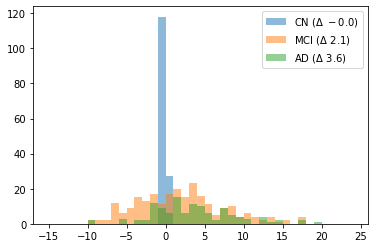

In [46]:
data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

bins = np.arange(-15,25)
plt.hist(age_deltas[groups == 0], bins=bins, alpha=0.5, label=f"CN ($\Delta ~ {age_deltas[groups == 0].mean():.1f}$)")
plt.hist(age_deltas[groups == 3], bins=bins, alpha=0.5, label=f"MCI ($\Delta ~ {age_deltas[groups == 3].mean():.1f}$)")
plt.hist(age_deltas[groups == 4], bins=bins, alpha=0.5, label=f"AD ($\Delta ~ {age_deltas[groups == 4].mean():.1f}$)")
plt.legend()
plt.show()

In [47]:
df = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df.columns = ['Delta', 'Group']
df['Group'] = df['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df.groupby('Group').agg([np.mean, np.std])

Delta          
           mean       std
Group                    
AD     3.635426  5.276085
CN    -0.034257  0.033880
MCI    2.061017  5.596952

## AD vs. CN

/opt/conda/envs/bruno/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


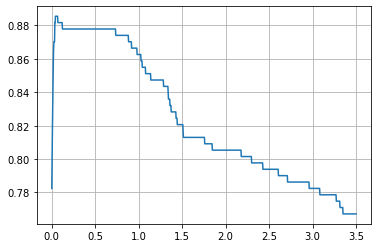

In [49]:
df_adcn = df[df['Group'] != 'MCI']
df_adcn['Label'] = df_adcn['Group'] == 'AD'

thresholds = np.linspace(0, 3.5, 1000)

accs = list()
for thresh in thresholds:
    pred = df_adcn['Delta'] > thresh
    accs.append(sum(pred == df_adcn['Label']) / len(pred))
accs = np.array(accs)

plt.plot(thresholds, accs)
plt.grid()
plt.show()

In [50]:
threshold = thresholds[np.argmax(accs)]
print(f"Best threshold = {threshold:.2f}")

Best threshold = 0.04


# Prediction

In [61]:
threshold = 2.62  # tuned using model trained only on training data
# threshold = 1.00  # tuned using model trained on train+val data

In [65]:
data = ADNIDataset(DATASET_FPATH, dataset='test')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

df_test = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df_test.columns = ['Delta', 'Group']
df_test['Group'] = df_test['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df_test.groupby('Group').agg([np.mean, np.std])

  0%|          | 0/770 [00:00<?, ?it/s]

Delta          
           mean       std
Group                    
AD     3.745560  5.832286
CN    -0.956460  3.790586
MCI    2.323889  5.493431

In [99]:
df_test

,Delta,Group
0,-1.316277,CN
1,-8.554657,CN
2,5.399956,MCI
3,-10.196373,MCI
4,5.902969,MCI
...,...,...
765,3.028854,AD
766,-2.441895,AD
767,-5.469353,CN
768,4.965820,MCI


In [104]:
from scipy.stats import f_oneway

f_oneway(df[df.Group == 'AD']['Delta'].values, df[df.Group == 'MCI']['Delta'].values, df[df.Group == 'CN']['Delta'].values)

F_onewayResult(statistic=20.874347814365052, pvalue=1.9604412647074833e-09)

In [66]:
df_adcn = df_test[df_test['Group'] != 'MCI']
labels = (df_adcn['Group'] == 'AD')

pred = df_adcn['Delta'] > threshold
acc = sum(pred == labels) / len(pred)

print(f"Test accuracy = {100*acc:.2f}%")
print(f"Test AUC = {roc_auc_score(pred, labels):.2f}")

Test accuracy = 68.21%
Test AUC = 0.68


# Cohen's D

In [113]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

cohen_d(age_deltas[groups == 4], age_deltas[groups == 0])

0.7680749020956529

In [114]:
cohen_d(age_deltas[groups == 3], age_deltas[groups == 0])

0.5414401416499476

In [115]:
cohen_d(age_deltas[groups == 4], age_deltas[groups == 3])

0.16079192157911917

# Analysis

In [9]:
runs_meta = pd.concat([pd.read_csv('../runs_meta.csv'), pd.read_csv('../new_runs_meta.csv')])
runs_meta = runs_meta.set_index('ID')
runs_meta

,Name,Group,Runtime,Notes,State,Tags,batch_size,epochs,learning_rate,loss_func,lr_scheduler,lr_scheduler_params.lr_lambda,model,split,train_loss,val_MAE,val_loss,val_ps_MAE
ID,,,,,,,,,,,,,,,,,,
10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,5462,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001078,3.399155,18.491207,3.054078
1nmolgfp,elated-oath-342,ADNI23_LR_UNet+old_MAPER,5316,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001096,3.458556,18.839183,3.068109
71b3v5g5,fast-sun-352,ADNI23_LR_UNet+old_MAPER,5518,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001064,3.416998,18.512721,3.095097
eu5yasfb,fine-wood-358,ADNI23_LR_UNet+old_MAPER,5458,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001111,3.387260,18.377423,3.060410
xq1n7hlt,royal-bee-346,ADNI23_LR_UNet+old_MAPER,5532,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001164,3.450090,18.841739,3.109362
1u0ce6cf,solar-forest-353,ADNI23_LR_UNet+old_FSL_BrainSeg,5149,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.044604,3.420150,18.155492,3.031086
1vj2xtnm,easy-water-343,ADNI23_LR_UNet+old_FSL_BrainSeg,4897,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.042271,3.381946,17.669436,2.980391
247apxie,driven-sun-359,ADNI23_LR_UNet+old_FSL_BrainSeg,5134,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.044849,3.409376,18.074892,3.022462
3s2psjrx,resilient-silence-365,ADNI23_LR_UNet+old_FSL_BrainSeg,5071,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.043376,3.400648,17.910982,3.034046


In [10]:
df = pd.concat([pd.read_csv('../preds.csv', index_col=0), pd.read_csv('../new_preds.csv', index_col=0)])
df

,Delta,Group,id,name,run_group,model,split,val_MAE,val_ps_MAE
0,-2.308647,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
1,-5.329765,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
2,6.313271,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
3,-6.215050,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
4,7.634407,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
...,...,...,...,...,...,...,...,...,...
765,-0.990280,AD,wdr5cu6u,silvery-eon-389,ADNI23_LR_ResNet50+BraTS,Sequential,train+val,3.521272,3.032702
766,-5.409432,AD,wdr5cu6u,silvery-eon-389,ADNI23_LR_ResNet50+BraTS,Sequential,train+val,3.521272,3.032702
767,-4.822861,CN,wdr5cu6u,silvery-eon-389,ADNI23_LR_ResNet50+BraTS,Sequential,train+val,3.521272,3.032702
768,4.006012,MCI,wdr5cu6u,silvery-eon-389,ADNI23_LR_ResNet50+BraTS,Sequential,train+val,3.521272,3.032702


In [11]:
summary = df.groupby(['id', 'Group', 'name', 'run_group', 'model'])['Delta'].agg([np.mean, np.std])
summary

mean  \
id       Group name                     run_group                   model                   
10b82odi AD    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       2.515800   
         CN    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet      -0.717357   
         MCI   misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       1.919315   
10hkql4a AD    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  2.378535   
         CN    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet -0.442463   
...                                                                                   ...   
wdr5cu6u CN    silvery-eon-389          ADNI23_LR_ResNet50+BraTS    Sequential  -0.451852   
         MCI   silvery-eon-389          ADNI23_LR_ResNet50+BraTS    Sequential   1.937837   
xq1n7hlt AD    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  2.399342   
         CN    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet -0.513093   
         MCI   royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  1.956519   

                                                                                      std  
id       Group name                     run_group                   model                  
10b82odi AD    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       6.151675  
         CN    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       3.681831  
         MCI   misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       5.920462  
10hkql4a AD    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  6.216727  
         CN    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  3.707944  
...                                                                                   ...  
wdr5cu6u CN    silvery-eon-389          ADNI23_LR_ResNet50+BraTS    Sequential   3.689195  
         MCI   silvery-eon-389          ADNI23_LR_ResNet50+BraTS    Sequential   5.856524  
xq1n7hlt AD    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  6.199940  
         CN    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  3.736309  
         MCI   royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  5.930340  

[120 rows x 2 columns]

In [13]:
from scipy.stats import kruskal, f_oneway, mannwhitneyu

analysis = list()
for run_id in df['id'].unique():
    run_data = df[df['id'] == run_id]
    run_data.groupby(['id', 'Group', 'name', 'run_group', 'model'])['Delta'].agg([np.mean, np.std])

    cn = run_data[run_data['Group'] == 'CN']['Delta'].values
    mci = run_data[run_data['Group'] == 'MCI']['Delta'].values
    ad = run_data[run_data['Group'] == 'AD']['Delta'].values

    analysis.append({
        'id': run_id,
        'group': runs_meta.loc[run_id]['Group'],
        'anova_cn_mci_F': f_oneway(cn, mci).statistic,
        'anova_cn_ad_F': f_oneway(cn, ad).statistic,
        'anova_mci_ad_F': f_oneway(mci, ad).statistic,
        'anova_cn_mci': f_oneway(cn, mci).pvalue,
        'anova_cn_ad': f_oneway(cn, ad).pvalue,
        'anova_mci_ad': f_oneway(mci, ad).pvalue,
        'kruskal_cn_mci_H': kruskal(cn, mci).statistic,
        'kruskal_cn_ad_H': kruskal(cn, ad).statistic,
        'kruskal_mci_ad_H': kruskal(mci, ad).statistic,
        'kruskal_cn_mci': kruskal(cn, mci).pvalue,
        'kruskal_cn_ad': kruskal(cn, ad).pvalue,
        'kruskal_mci_ad': kruskal(mci, ad).pvalue,
        'mannwhitneyu_cn_mci_H': mannwhitneyu(cn, mci).statistic,
        'mannwhitneyu_cn_mci': mannwhitneyu(cn, mci).pvalue,
        'mannwhitneyu_cn_ad_H': mannwhitneyu(cn, ad).statistic,
        'mannwhitneyu_cn_ad': mannwhitneyu(cn, ad).pvalue,
        'mannwhitneyu_mci_ad_H': mannwhitneyu(mci, ad).statistic,
        'mannwhitneyu_mci_ad': mannwhitneyu(mci, ad).pvalue,
    })
analysis = pd.DataFrame(analysis)

analysis.groupby('group')[['kruskal_cn_mci', 'kruskal_cn_ad', 'kruskal_mci_ad',
                           'anova_cn_mci', 'anova_cn_ad', 'anova_mci_ad',
                           'mannwhitneyu_cn_mci', 'mannwhitneyu_cn_ad', 'mannwhitneyu_mci_ad']].agg([np.mean, np.std])

kruskal_cn_mci               kruskal_cn_ad  \
                                            mean           std          mean   
group                                                                          
ADNI23_LR_ResNet50                  2.321704e-06  1.760229e-06  6.619128e-06   
ADNI23_LR_ResNet50+BraTS            2.341697e-07  8.350416e-08  1.083112e-06   
ADNI23_LR_ResNet50+ImageNet         2.812726e-08  1.899577e-08  4.403642e-07   
ADNI23_LR_ResNet50+ImageNet+BraTS   2.946523e-08  9.086360e-09  4.022334e-08   
ADNI23_LR_UNet                      3.354186e-09  3.563922e-09  8.165333e-09   
ADNI23_LR_UNet+BraTS                5.409818e-10  2.541590e-10  1.214406e-10   
ADNI23_LR_UNet+old_FSL_BrainSeg     5.462836e-09  1.925608e-09  3.575157e-09   
ADNI23_LR_UNet+old_MAPER            3.088445e-07  2.344742e-07  2.748234e-06   

                                                kruskal_mci_ad            \
                                            std           mean       std   
group                                                                      
ADNI23_LR_ResNet50                 4.247419e-06       0.275472  0.050955   
ADNI23_LR_ResNet50+BraTS           7.273709e-07       0.270739  0.057210   
ADNI23_LR_ResNet50+ImageNet        3.520524e-07       0.277428  0.051108   
ADNI23_LR_ResNet50+ImageNet+BraTS  6.551725e-09       0.157229  0.021525   
ADNI23_LR_UNet                     8.611432e-09       0.138127  0.022408   
ADNI23_LR_UNet+BraTS               7.568602e-11       0.058605  0.009495   
ADNI23_LR_UNet+old_FSL_BrainSeg    1.355327e-09       0.103218  0.014539   
ADNI23_LR_UNet+old_MAPER           1.774789e-06       0.355239  0.014330   

                                   anova_cn_mci                 anova_cn_ad  \
                                           mean           std          mean   
group                                                                         
ADNI23_LR_ResNet50                 4.767096e-07  3.309682e-07  6.102281e-08   
ADNI23_LR_ResNet50+BraTS           5.086291e-08  1.612764e-08  8.490160e-09   
ADNI23_LR_ResNet50+ImageNet        6.261224e-09  4.489600e-09  1.646897e-09   
ADNI23_LR_ResNet50+ImageNet+BraTS  8.632663e-09  3.774627e-09  1.234138e-10   
ADNI23_LR_UNet                     1.078768e-09  1.234542e-09  2.256009e-11   
ADNI23_LR_UNet+BraTS               2.411829e-10  9.494573e-11  2.407916e-13   
ADNI23_LR_UNet+old_FSL_BrainSeg    1.258517e-09  3.014102e-10  1.230294e-11   
ADNI23_LR_UNet+old_MAPER           6.156738e-08  3.940858e-08  2.336335e-08   

                                                anova_mci_ad            \
                                            std         mean       std   
group                                                                    
ADNI23_LR_ResNet50                 4.847862e-08     0.332111  0.056219   
ADNI23_LR_ResNet50+BraTS           7.701829e-09     0.339529  0.057337   
ADNI23_LR_ResNet50+ImageNet        1.528392e-09     0.335354  0.059073   
ADNI23_LR_ResNet50+ImageNet+BraTS  2.904720e-11     0.191174  0.023037   
ADNI23_LR_UNet                     2.317241e-11     0.146215  0.027094   
ADNI23_LR_UNet+BraTS               1.076415e-13     0.071738  0.008630   
ADNI23_LR_UNet+old_FSL_BrainSeg    3.895527e-12     0.127080  0.014447   
ADNI23_LR_UNet+old_MAPER           1.501231e-08     0.407082  0.012672   

                                  mannwhitneyu_cn_mci                \
                                                 mean           std   
group                                                                 
ADNI23_LR_ResNet50                       1.162226e-06  8.811261e-07   
ADNI23_LR_ResNet50+BraTS                 1.172368e-07  4.180469e-08   
ADNI23_LR_ResNet50+ImageNet              1.408308e-08  9.510661e-09   
ADNI23_LR_ResNet50+ImageNet+BraTS        1.475305e-08  4.549312e-09   
ADNI23_LR_UNet                           1.679545e-09  1.784491e-09   
ADNI23_LR_UNet+BraTS                     2.709080e-10  1.272719

In [14]:
analysis.to_csv('statistical_analysis.csv')

In [17]:
df.head()

,Delta,Group,id,name,run_group,model,split,val_MAE,val_ps_MAE
0,-2.308647,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
1,-5.329765,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
2,6.313271,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
3,-6.215050,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
4,7.634407,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078


In [28]:
from scipy.stats import kruskal, f_oneway

analysis = list()
for group in df['run_group'].unique():
    group_data = df[df['run_group'] == group]
#     group_data.groupby(['Group', 'run_group', 'model'])['Delta'].agg([np.mean, np.std])

    cn = group_data[group_data['Group'] == 'CN']['Delta'].values
    mci = group_data[group_data['Group'] == 'MCI']['Delta'].values
    ad = group_data[group_data['Group'] == 'AD']['Delta'].values

    analysis.append({
        'group': group,
        'anova_cn_mci_F': f_oneway(cn, mci).statistic,
        'anova_cn_ad_F': f_oneway(cn, ad).statistic,
        'anova_mci_ad_F': f_oneway(mci, ad).statistic,
        'anova_cn_mci': f_oneway(cn, mci).pvalue,
        'anova_cn_ad': f_oneway(cn, ad).pvalue,
        'anova_mci_ad': f_oneway(mci, ad).pvalue,
        'kruskal_cn_mci_H': kruskal(cn, mci).statistic,
        'kruskal_cn_ad_H': kruskal(cn, ad).statistic,
        'kruskal_mci_ad_H': kruskal(mci, ad).statistic,
        'kruskal_cn_mci': kruskal(cn, mci).pvalue,
        'kruskal_cn_ad': kruskal(cn, ad).pvalue,
        'kruskal_mci_ad': kruskal(mci, ad).pvalue,
    })
analysis = pd.DataFrame(analysis)
analysis
# analysis.groupby('group')[['kruskal_cn_mci', 'kruskal_cn_ad', 'kruskal_mci_ad',
#                            'anova_cn_mci', 'anova_cn_ad', 'anova_mci_ad']].agg([np.mean, np.std])

,group,anova_cn_mci_F,anova_cn_ad_F,anova_mci_ad_F,anova_cn_mci,anova_cn_ad,anova_mci_ad,kruskal_cn_mci_H,kruskal_cn_ad_H,kruskal_mci_ad_H,kruskal_cn_mci,kruskal_cn_ad,kruskal_mci_ad
0,ADNI23_LR_UNet+old_MAPER,153.439281,165.587476,3.452664,2.089332e-34,1.983551e-36,0.063257,133.994606,111.669967,4.437348,5.478410e-31,4.220276e-26,0.035161
1,ADNI23_LR_UNet+old_FSL_BrainSeg,191.064781,245.666329,11.742164,3.529058e-42,3.092141e-52,0.000620,171.183528,175.377539,13.233398,4.080161e-39,4.951791e-40,0.000275
2,ADNI23_LR_UNet+BraTS,208.706853,290.055060,16.361058,8.662319e-46,9.656394e-61,0.000054,193.673891,209.045002,17.977614,5.016943e-44,2.219328e-47,0.000022
3,ADNI23_LR_UNet,196.243248,242.852288,10.692621,3.060460e-43,1.085025e-51,0.001089,178.014015,170.269648,11.018345,1.315390e-40,6.460603e-39,0.000902
4,ADNI23_LR_ResNet50+ImageNet,176.406822,196.955896,4.714616,3.660344e-39,1.075448e-42,0.029993,155.928165,131.061919,5.982752,8.777382e-36,2.400021e-30,0.014446
5,ADNI23_LR_ResNet50,132.685915,156.008590,4.771602,4.483882e-30,1.700858e-34,0.029017,114.762619,104.343518,6.127350,8.870510e-27,1.701114e-24,0.013311
6,ADNI23_LR_ResNet50+ImageNet+BraTS,171.916773,219.894456,8.619130,3.093078e-38,3.240016e-47,0.003354,154.314204,151.820386,10.009865,1.977258e-35,6.935571e-35,0.001557
7,ADNI23_LR_ResNet50+BraTS,153.113997,176.441765,4.628688,2.441461e-34,1.312687e-38,0.031529,134.438796,120.433728,6.085030,4.380177e-31,5.083703e-28,0.013633


In [14]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



8506561

In [16]:
from nnunet.training.model_restore import restore_model

nnunet_model_fpath = '/home/jupyter/gama/nnUNet/models/nnUNet/2d/Task102_BraTS2020/nnUNetTrainerV2_ResNetUNet__nnUNetPlans_ResNetUNet_v2.1/all_pretrain/model_final_checkpoint.model.pkl'
nnunet_trainer = restore_model(nnunet_model_fpath, train=False)
nnunet_trainer.initialize(training=False)
resnet_encoder = nnunet_trainer.network.encoder
resnet_encoder.default_return_skips = False
net = nn.Sequential(
    resnet_encoder,
    nn.AdaptiveAvgPool2d(output_size=(1,1)),
    nn.Flatten(1),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
)

count_parameters(net)

2023-02-14 18:50:12.899126: WARNING! old plans file with missing pool_op_kernel_sizes. Attempting to fix it...
2023-02-14 18:50:12.899520: WARNING! old plans file with missing conv_kernel_sizes. Attempting to fix it...
2023-02-14 18:50:12.900499: WARNING! old plans file with missing pool_op_kernel_sizes. Attempting to fix it...
2023-02-14 18:50:12.900632: WARNING! old plans file with missing conv_kernel_sizes. Attempting to fix it...


25607248

## p-value Models

In [6]:
net = torch.load('/home/jupyter/gama/bruno/models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '733bq6g5').to(device)  # efficient-mountain-368
# net = load_from_wandb(net, '18721a16').to(device)  # electric-cherry-345
net.eval()
net



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [26]:
from nnunet.training.model_restore import restore_model

nnunet_model_fpath = '/home/jupyter/gama/nnUNet/models/nnUNet/2d/Task102_BraTS2020/nnUNetTrainerV2_ResNetUNet__nnUNetPlans_ResNetUNet_v2.1/all_pretrain/model_final_checkpoint.model.pkl'
nnunet_trainer = restore_model(nnunet_model_fpath, checkpoint=nnunet_model_fpath[:-4], train=False)
nnunet_trainer.initialize(training=False)
resnet_encoder = nnunet_trainer.network.encoder
resnet_encoder.default_return_skips = False
net = nn.Sequential(
    resnet_encoder,
    nn.AdaptiveAvgPool2d(output_size=(1,1)),
    nn.Flatten(1),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
)
net = load_from_wandb(net, '2tu1q3ge').to(device)  # efficient-mountain-368
# net = load_from_wandb(net, '18721a16').to(device)  # electric-cherry-345
net.eval()
net

2023-03-08 12:01:53.348563: WARNING! old plans file with missing pool_op_kernel_sizes. Attempting to fix it...
2023-03-08 12:01:53.348844: WARNING! old plans file with missing conv_kernel_sizes. Attempting to fix it...
2023-03-08 12:01:53.349231: loading checkpoint /home/jupyter/gama/nnUNet/models/nnUNet/2d/Task102_BraTS2020/nnUNetTrainerV2_ResNetUNet__nnUNetPlans_ResNetUNet_v2.1/all_pretrain/model_final_checkpoint.model train= False
2023-03-08 12:01:53.349848: WARNING! old plans file with missing pool_op_kernel_sizes. Attempting to fix it...
2023-03-08 12:01:53.349986: WARNING! old plans file with missing conv_kernel_sizes. Attempting to fix it...
2023-03-08 12:01:54.797990: self.was_initialized is True, not running self.initialize again


Sequential(
  (0): ResNetEncoder(
    (channel_adapter): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (stages): ModuleList(
      (0): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), s

In [7]:
class ADNIDatasetClassification(ADNIDataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
        get_age=False,
        labels=['CN','AD'],
    ) -> None:
        super().__init__(
            hdf5_fpath=hdf5_fpath,
            transform=transform,
            dataset=dataset,
        )

        self._labels_order = np.array(['CN', 'EMCI', 'LMCI', 'MCI', 'AD', 'SMC'])
        self.labels = labels
        self._labels_i_order = np.where(np.isin(self._labels_order, self.labels))[0]

        self.get_age = get_age

        self._update_idx()

    def _update_idx(self):
        with h5py.File(self._fpath, 'r') as h:
            # get true length
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

            y_is_labels = np.full((l,), False)
            for label in self.labels:
                label_i = np.where(self._labels_order == label)[0]

                if self.dataset == 'train+val':
                    y_is_label_train = h['train']['y'][:] == label_i
                    y_is_label_val = h['val']['y'][:] == label_i
                    y_is_label = np.concatenate([y_is_label_train, y_is_label_val])
                else:
                    y_is_label = h[self.dataset]['y'][:] == label_i

                y_is_labels |= y_is_label

        self._idx = np.where(y_is_labels)[0]

    def __len__(self):
        # Uncomment the line below if the dataset changes along the usage
#         self._update_idx()

        return len(self._idx)

    def fix_label(self, label):
        try:
            labels_i_orders = np.stack([self._labels_i_order,] * label.shape[0]).T
            relative_label = np.apply_along_axis(np.where, 0, labels_i_orders == label)
        except IndexError:
            relative_label = np.where(self._labels_i_order == label)

        return relative_label[0][0]

    def __getitem__(self, index: int):
        if self.get_age:
            img, age, label = super().__getitem__(self._idx[index])

            return img, age, self.fix_label(label)
        else:
            img, label = super().__getitem__(self._idx[index])

            return img, self.fix_label(label)

    def _get_item(self, dataset, index_):
        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            if self.get_age:
                age = h[dataset]['a'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        if self.get_age:
            return img, age, label
        else:
            return img, label

data = ADNIDatasetClassification(
    DATASET_FPATH,
    get_age=True,
    dataset='test',
    labels=['CN','MCI','AD'],
)
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        X = X.unsqueeze(1)
#         try:
#             n = net.conv1.in_channels
#             X = X.repeat((1,n,1,1))  # fix input channels
#         except:
#             pass
        try:
            n = net[0].stages[0].in_channels
            X = X.repeat((1,n,1,1))  # fix input channels
        except:
            pass
        a_pred = h(net(X.to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

df = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df.columns = ['Delta', 'Group']
df['Group'] = df['Group'].replace({0:'CN', 1:'MCI', 2:'AD'})

df

  0%|          | 0/770 [00:00<?, ?it/s]

,Delta,Group
0,-1.982658,CN
1,-6.715790,CN
2,6.263924,MCI
3,-8.198364,MCI
4,5.702805,MCI
...,...,...
765,0.784843,AD
766,-4.080322,AD
767,-4.410347,CN
768,3.719208,MCI


In [8]:
from scipy.stats import kruskal, f_oneway, mannwhitneyu

cn = df[df['Group'] == 'CN']['Delta'].values
mci = df[df['Group'] == 'MCI']['Delta'].values
ad = df[df['Group'] == 'AD']['Delta'].values

for k,v in {
    'anova_mci_ad_F': f_oneway(mci, ad).statistic,
    'anova_mci_ad': f_oneway(mci, ad).pvalue,
    'kruskal_mci_ad_H': kruskal(mci, ad).statistic,
    'kruskal_mci_ad': kruskal(mci, ad).pvalue,
    'mannwhitneyu_mci_ad_H': mannwhitneyu(mci, ad).statistic,
    'mannwhitneyu_mci_ad': mannwhitneyu(mci, ad).pvalue,
}.items():
    print(k, v)

anova_mci_ad_F 3.5247265251767095
anova_mci_ad 0.06099267975606921
kruskal_mci_ad_H 4.077612405330228
kruskal_mci_ad 0.043455021274980236
mannwhitneyu_mci_ad_H 28469.0
mannwhitneyu_mci_ad 0.02174270995495763


In [34]:
class BraTSDataset(Dataset):
    def __init__(
        self,
        imgs_dir='/home/jupyter/gama/nnUNet/data/processed/Task102_BraTS2020/nnUNetData_plans_v2.1_2D_stage0/',
        meta_fpath='/home/jupyter/gama/nnUNet/data/raw/survival_info.csv',
        plans_fpath='/home/jupyter/gama/nnUNet/data/processed/Task102_BraTS2020/nnUNetPlans_FabiansResUNet_v2.1_plans_2D.pkl',
        transform=torch.Tensor,
    ) -> None:
        super().__init__()

        self.imgs_dir = Path(imgs_dir)

        assert self.imgs_dir.exists()

        self.meta = pd.read_csv(meta_fpath).set_index('Brats20ID')
        with open(plans_fpath, 'rb') as f:
            plans = pickle.load(f)
        self.patch_size = np.array([192, 192])

        self.transform = transform

    def __len__(self):
        return self.meta.shape[0] * 80

    def __getitem__(self, index: int):
        lb = 35
        ub = 115
        
        i = index // 80
        j = index % 80

        img_id = self.meta.iloc[i].name
        label = float(self.meta.iloc[i]['Age'])

        img_meta_fpath = self.imgs_dir/f"{img_id}.pkl"
        with open(img_meta_fpath, 'rb') as f:
            img_meta = pickle.load(f)
        crop_offset = img_meta['crop_bbox'][0][0]

        full_img_fpath = self.imgs_dir/f"{img_id}.npz"
        img = np.load(full_img_fpath)['data'][0, 35 - crop_offset + j]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        # pad
        pad = self.patch_size - img.shape
        pad_left = (pad / 2).astype(int)
        pad_right = (0.5 + pad / 2).astype(int)

        f_pad = np.empty((pad_left.size + pad_right.size,), dtype=pad_left.dtype)
        f_pad[0::2] = pad_left
        f_pad[1::2] = pad_right

        img = torch.nn.functional.pad(img, f_pad.tolist()[::-1]).unsqueeze(0)[:,:192,:192]

        return img, label
brats_dataset = BraTSDataset()
len(brats_dataset)

18880

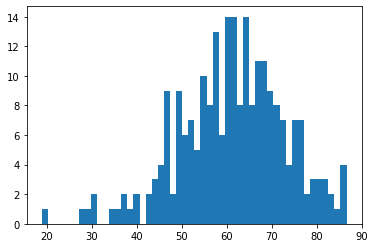

In [43]:
%matplotlib inline

ages = brats_dataset.meta['Age'].values
plt.hist(ages, bins=50)
plt.show()

In [52]:
np.mean(np.abs(np.array(ages) - np.median(ages)))

9.280457627118645

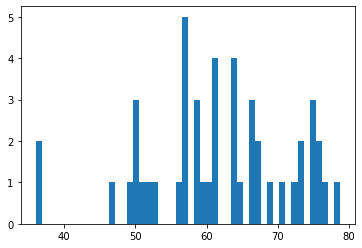

In [46]:
n_val = int(0.2 * len(ages))

plt.hist(ages[-n_val:], bins=50)
plt.show()

In [53]:
np.mean(np.abs(np.array(ages[-n_val:]) - np.median(ages[-n_val:])))

7.864510638297873

50.0


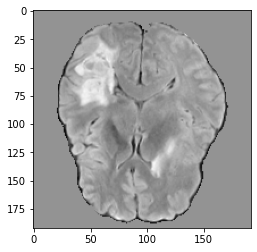

In [56]:
X, y = brats_dataset[-n_val + 5]
print(y)
plt.imshow(X[0], cmap='gray')
plt.show()

60.463


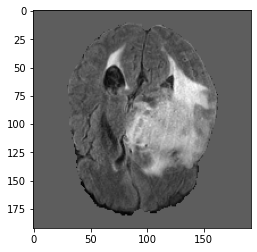

In [57]:
X, y = brats_dataset[-n_val + 85]
print(y)
plt.imshow(X[0], cmap='gray')
plt.show()